# Workbook for the 4-way mutual inhibition model

This notebook contains the flow of development for Carlos' version of the 4-way MI network for the superior colliculus (SC) in the ProAnti task

<h1 id="tocheading">TABLE OF CONTENTS</h1>
<div id="toc"></div>

**Updates to the table of contents are periodic, but run the cell below to first start or force an update.**

In [2]:
%%javascript
$.getScript('https://sites.google.com/site/brodylabhome/files/make_table_of_contents.js')


<IPython.core.display.Javascript object>

# 0) The path so far to finding model parameters

We wanted to set up something where the Pro vs. Anti signal from PFC biased competition when the light got turned on later. If we initally set up a bistable system (stable points (1,0,0,1) and (0,1,1,0) only, then this is very difficult. Because before the light comes on we're always trying to stop the system from flowing off to one of those stable points. 

We can try to do this by having different amounts of overall excitation during rule/delay periods versus target periods, since that difference can put us across a bifurcation: low E and we have only one stable point, high E and we have two stable points (as in Machens, Romo, Brody, 2005). But during the delay, we also wanted to have very little competition betweem Right and Left sides, so we don't start with too much of a bias. Maybe such a bias could have been overcome with a strong target light signal, but in any event, that path was not pursued here.

Instead, the idea pursued here was to set up a tri-stable system, with stable points at (0,0,0,0), (1,0,0,1) and (0, 1, 1, 0). That way the dynamics of the system themselves prevent runaway excitation during the rule-delay period, and quench R vs L excitation during the same period.


In [3]:
%matplotlib notebook

import matplotlib
if matplotlib.get_backend()=="Qt4Agg":
    using_qt = True
else:
    using_qt = False
    
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin
import time
                                                                                                                                                                            
from my_plot_utilities import *

%load_ext autoreload

# Set some default values for graphics plots
import matplotlib as mpl
mpl.rcParams["font.size"] = 16
mpl.rcParams["font.family"] = 'Arial'
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["lines.markersize"] = 8

In [4]:
%autoreload
from my_plot_utilities import *

if using_qt:
    right_hand_fig(1)
    right_hand_fig(2)
    
    

In [5]:
plt.get_fignums()

[]

# 1) The main dynamics function

In [6]:
class MyError(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)



def run_dynamics(trial_type, opto='off', opto_scaling=0.5, opto_scale_on_E=1,
                 right_light_pro_extra = 0.25, right_light_input=1, 
                vwi = 1.5, hwi = 1.5, pro_self_ex = 0, anti_self_ex = 0, tau=0.1,
                dt=0.02, const_E = 0.15, target_extra_E = 0.25,
                pfc_anti_input = 0.05, pfc_pro_input = np.nan, const_pro_bias = 0,
                sigma=0.1,
                start_U = [-7, -7, -7, -7], do_plot = True,
                g_leak = 0.5, U_rest = -1,
                fignum=1, theta = 1, 
                rule_period = 0.5, delay_period = 0.5, target_period = 0.1,
                post_target_period = 0.5):
    """
    Runs the 4-way mutual inhibition model
    
    PARAMS:
    -------
    
        trial_type    Must be either "pro" or "anti"
        U_rest = -1     Resting point for U in the absance of other inputs
        g_leak = 0.5    Mutliplies (U_rest - U) for the dynamics
        theta = 1       Threshold on U for sigmoidal transform from U to V 
        dt=0.02         Timestep
        sigma=0.1,      added standard deviation on U per unit time
        rule_period = 0.5       in seconds
        delay_period = 0.5      in seconds. Opto will happen during this period
        target_period = 0.1     right_light_input and target_extra_E will happen during this period; 
                                Pro v Anti input will be turned off; 
        post_target_period = 0.5  target_extra_E will still be on, but right_side_input won't
        tau=0.1         Time constant of dynamics, insecs
        start_U = [-7, -7, -7, -7]
        const_E = 0.15  Constant excitation added to all units
        right_light_input=1     Extra excitation to right side of the brain units during the target period
        right_light_pro_extra   Even further excitation added to pro Right side units during target
        vwi = 1.5       Weight between ProContra and AntiIpsi units (on each side of the brain)
        hwi = 1.5       Weight between ProContra units across the brain; also between AntiContra
        pro_self_ex = 0   Self excitation weight of Pro units
        anti_self_ex = 0  Self excitation weight of Anti units
        pfc_anti_input = 0.05    Input to Anti units during rule and delay periods
        pfc_pro_input = np.nan   Input to Pro units during rule and delay periods (default means same as Anti)
        const_pro_bias = 0       A constant extra input to the Pro units
        target_extra_E = 0.25    Extra excitation added to all units during target and post_target periods
        opto='off'    Whether there is optogenetic-induced scaling of outputs.
                      Will be done during the delay period only
           opto_scaling=0.5      Factor by which to scale the weight matrix during opto 
           opto_scale_on_E=1     Factor by which to scale the constant excitation during opto
        unilateral_opto = False If True, then opto_scale_on_E will be forced to 0, and opto_scaling will apply
                                to only one side
        do_plot = True  whether or not to plot the results
        fignum=1        figure on which to plot

    RETURNS:
    --------
        
        t    Time vector
        U   U matrix, size 4-by-len(t). Order is ProContra on right side, AntiIpsi on right
                    side, ProContra on left side, AntiIpsi on left.
        V   V matrix = 0.5*np.tanh(U-theta) + 0.5
        W   Weight matrix between units
        
    """

    t = np.arange(0, rule_period + delay_period + target_period + post_target_period, dt) 

    if np.isnan(pfc_pro_input):
        pfc_pro_input = pfc_anti_input
        
    V = np.zeros((4, len(t)))   # order is pro right, anti right, pro left, anti left
    U = np.zeros((4, len(t)))
    if type(start_U)==list:
        start_U = np.array(start_U)
    U[:,0] = start_U

    W = np.array([[pro_self_ex, -vwi, -hwi, 0], [-vwi, anti_self_ex, 0, -hwi], 
             [-hwi, 0, pro_self_ex, -vwi], [0, -hwi, -vwi, anti_self_ex]])

    
    for i in range(1, len(t)):
        if rule_period <= t[i] and t[i] <= rule_period + delay_period and opto=="on":
            myW = W.copy()*opto_scaling
            myE = const_E*opto_scale_on_E
        else:
            myW = W.copy()
            myE = const_E

        dUdt = myE + myW @ V[:,i-1] + g_leak*(U_rest - U[:,i-1])
        
        if t[i] < rule_period + delay_period:
            if trial_type=='anti':
                dUdt[[1,3]] += pfc_anti_input
            elif trial_type == 'pro':
                dUdt[[0,2]] += pfc_pro_input
            else:
                raise Myerror("what trial type was this???")
        elif t[i] < rule_period + delay_period + target_period:
            dUdt[[0,1]] += right_light_input
            dUdt[0] += right_light_pro_extra
            dUdt += target_extra_E
        else:
            dUdt += target_extra_E
        
        U[:,i] = U[:,i-1] + (dt/tau)*dUdt + sigma*np.random.randn(4)*np.sqrt(dt)
        
        V[:,i] = 0.5*np.tanh(U[:,i]-theta) + 0.5
            
    if do_plot:
        plt.figure(fignum)
        plt.subplot(2,1,1)
        h = plt.plot(t, V.T); 
        h[0].set_color([0, 0, 1])
        h[1].set_color([1, 0, 0])
        h[2].set_color([1, 0.5, 0.5])
        h[3].set_color([0, 1, 1])
        plt.ylabel("V")

        ax = plt.gca()
        yl = list(ax.get_ylim())
        plt.vlines([rule_period, rule_period+delay_period, 
                    rule_period+delay_period+target_period], 
                   -0.05, 1.05)
        if yl[0]<0.02:
            yl[0] = -0.02
        if yl[1]>0.98:
            yl[1] = 1.02
        ax.set_ylim(yl)
        
        plt.subplot(2,1,2)
        hu = plt.plot(t, U.T)
        hu[0].set_color([0, 0, 1])
        hu[1].set_color([1, 0, 0])
        hu[2].set_color([1, 0.7, 0.5])
        hu[3].set_color([0, 1, 1])
        plt.xlabel("secs"); plt.ylabel("U")

            
    return t, U, V, W

# 2) TRISTABILITY: 

This was facilitated by setting all light inputs, PFC inputs, etc. to zero, and just looking at different starting points: over repeated runs, did they reliably lead to different ending points? (Of course guesses as to good starting points similar to our desired stable states were used to check, not random starting points.) A very long delay period, and non-negligible noise was used to help check.

Even that wasn't enough. Goign back to Wong and Wang J. Neurosci. 2005, a two-node tristable system can be created by weakening overall excitation and replacing it with some self-excitation (thus when the node is inactive its E input has been reduced, but when active its E input is strong). So horizontal weights were set to zero, turning the network into two totally independent two-node networks. Only when tristability was established there were the horizontal weights turned back on. Some tweaking to reduce excitation was still necessary after that, but it was not too hard.


the following set of parameters reliably sets up three stable points.
You can see them by starting at
  start_U = [-1, -1, -1, -1]
      or
  start_U = [1, -1, -1, 1]
      or
  start_U = [-1, 1, 1, -1]
      
Note that theta=1, and that const_E is a bit fine-tuned: 0.2 is too much, and 0.16 too little

**Note that there are no inputs here, this is just seeing what the stable points of the network are by looking at different starting points.**


<IPython.core.display.Javascript object>


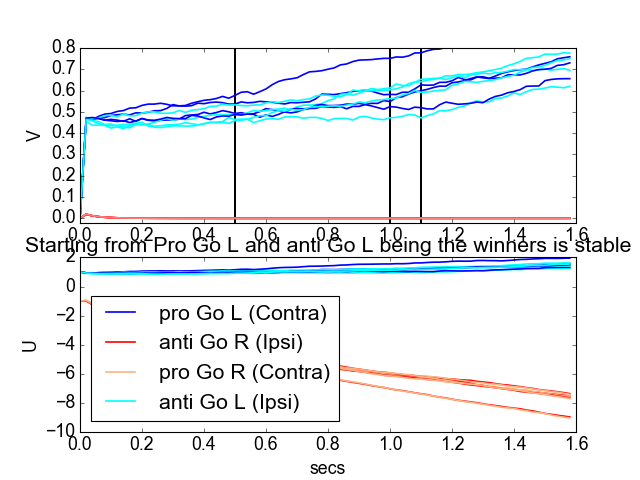

<IPython.core.display.Javascript object>


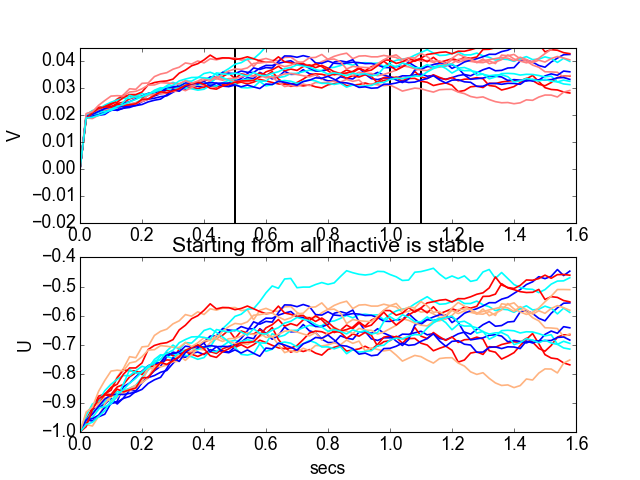

In [7]:
ntrys = 4; answers = np.zeros((3,ntrys))
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1
    
plt.figure(fig1); plt.clf()
plt.figure(fig2); plt.clf()

for i in range(0, ntrys):
    t, U, V, W = run_dynamics('anti', opto='off', opto_scaling=0.5, opto_scale_on_E=-1,  
                       right_light_pro_extra = 0, right_light_input=0,
                       sigma=0.1,
                       vwi = 1.5, hwi = 1.5, const_E = 0.18, target_extra_E=0,
                       pfc_anti_input = 0,
                       pro_self_ex=0.7, anti_self_ex=0.7,
                       start_U = [1, -1, -1, 1], g_leak = 0.25, theta=1, fignum=fig1)
    
    t, U, V, W = run_dynamics('anti', opto='off', opto_scaling=0.5, opto_scale_on_E=-1,  
                       right_light_pro_extra = 0, right_light_input=0,
                       sigma=0.1,
                       vwi = 1.5, hwi = 1.5, const_E = 0.18, target_extra_E=0,
                       pfc_anti_input = 0,
                       pro_self_ex=0.7, anti_self_ex=0.7,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig2)

plt.figure(fig1)    
plt.legend(['pro Go L (Contra)', 'anti Go R (Ipsi)', 'pro Go R (Contra)', 'anti Go L (Ipsi)'], 
           loc="lower left")
plt.title("Starting from Pro Go L and anti Go L being the winners is stable")

plt.figure(fig2)
plt.title("Starting from all inactive is stable")


# 3) Setting the pro vs anti bias from PFC

That just required adding little enough bias that we stay in the vicinity of (0,0,0,0) during the rule/delay; but still, with reasonable noise, during anti trials the two anti units have activity noticeably above the two pro nodes. And vice versa.


<IPython.core.display.Javascript object>


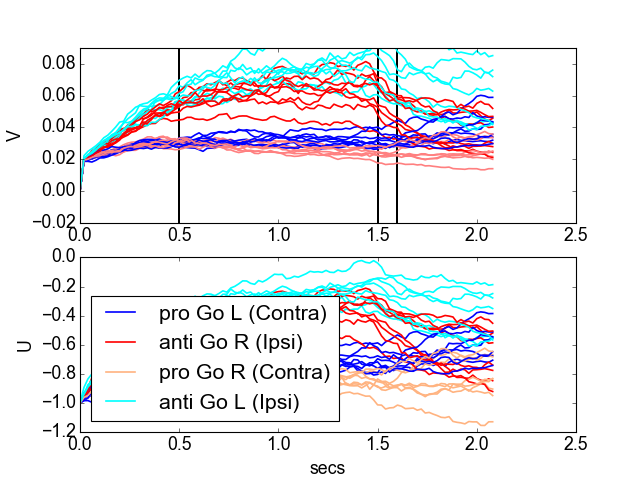

In [8]:
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1


plt.figure(fig1); plt.clf();


ntrys = 8; answers = np.zeros((3,ntrys))

for i in range(0, ntrys):
    t, U, V, W = run_dynamics('anti', opto='off', opto_scaling=0.5, opto_scale_on_E=-1,  
                       right_light_pro_extra = 0, right_light_input=0,
                       sigma=0.1,
                       vwi = 1.5, hwi = 1.5, const_E = 0.18, target_extra_E=0,
                       pfc_anti_input = 0.1,
                       pro_self_ex=0.7, anti_self_ex=0.7,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig1,
                       delay_period = 1)
    

plt.figure(fig1)    
plt.legend(['pro Go L (Contra)', 'anti Go R (Ipsi)', 'pro Go R (Contra)', 'anti Go L (Ipsi)'], 
           loc="lower left")


# 4) CORRECT TARGET SELECTION: 
Then it was time to turn on the side light. Worked pretty well straight off. Just needed to be enough kick the system out of the (0,0,0,0) stable point, but not so much that it overwhelmed the bias set up during the delay.  After this, adding a little extra strength to the light->Pro units made for a bias in favor of Pro.  Teh goal is to exploit that bias during Opto silencing of the delay period.

This set of parameters can be used to go Left on Pro trials
and go right on Anti trials, most of the time but not always. (Light is always from the 
left). In other words, the pro vs anti signal during the rule and delay is biasing the
competition in the expected way. About 84% correct

  

<IPython.core.display.Javascript object>


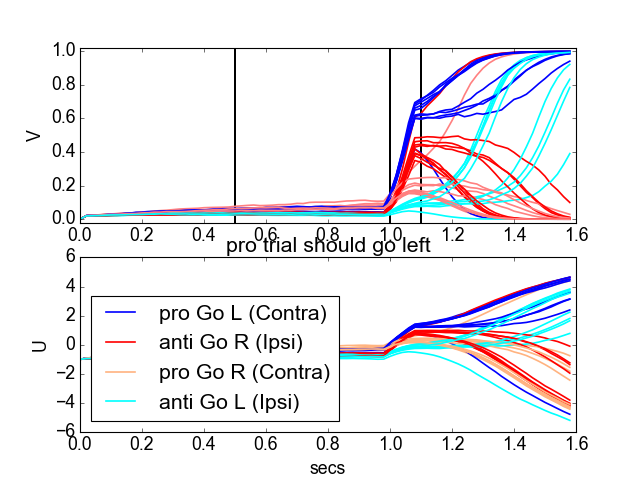

<IPython.core.display.Javascript object>


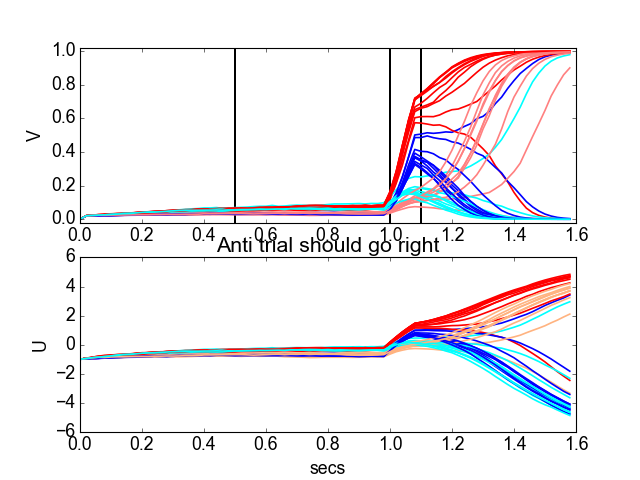

In [9]:
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1


plt.figure(fig1); plt.clf();
plt.figure(fig2); plt.clf();

ntrys = 10; answers = np.zeros((3,ntrys))

for i in range(0, ntrys):
    t, U, V, W = run_dynamics('pro', opto='off', opto_scaling=0.5, opto_scale_on_E=-1,  
                       right_light_pro_extra = 0, right_light_input=1,
                       sigma=0.1,
                       vwi = 1.5, hwi = 1.5, const_E = 0.19, target_extra_E=1,
                       pfc_anti_input = 0.1,
                       pro_self_ex=0.7, anti_self_ex=0.7,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig1)

    t, U, V, W = run_dynamics('anti', opto='off', opto_scaling=0.5, opto_scale_on_E=-1,  
                       right_light_pro_extra = 0, right_light_input=1,
                       sigma=0.1,
                       vwi = 1.5, hwi = 1.5, const_E = 0.19, target_extra_E=1,
                       pfc_anti_input = 0.1,
                       pro_self_ex=0.7, anti_self_ex=0.7,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig2)
    
plt.figure(fig1)    
plt.legend(['pro Go L (Contra)', 'anti Go R (Ipsi)', 'pro Go R (Contra)', 'anti Go L (Ipsi)'], 
           loc="lower left")
plt.title("pro trial should go left")

plt.figure(fig2)
plt.title("Anti trial should go right")

# 5) PRO BIAS: 
If we take the parameters below and simply add right_light_pro_extra = 0.1,
we get 90% correct on pro trials but 75% correct on Anti. A Pro bias



In [10]:
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1

    
ntrys = 400; answers = np.zeros((3,ntrys))

for i in range(0, ntrys):
    t, U, V, W = run_dynamics('pro', opto='off', opto_scaling=0.5, opto_scale_on_E=-1,  
                       right_light_pro_extra = 0.1, right_light_input=1,
                       sigma=0.1,
                       vwi = 1.5, hwi = 1.5, const_E = 0.19, target_extra_E=1,
                       pfc_anti_input = 0.1,
                       pro_self_ex=0.7, anti_self_ex=0.7, do_plot=False,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig1)

    if V[0,-1] > 0.5 and V[3,-1] > 0.5:
        answers[0,i] = 1
    elif V[1,-1] > 0.5 and V[2,-1] > 0.5:
        answers[1,i] = 1
    else:
        answers[2,i] = 1

print("PRO should go Left")
print("   L = ", 100*np.mean(answers, 1)[0], "%,  ",
      "   R = ", 100*np.mean(answers, 1)[1], "%,  ",
      "   U = ", 100*np.mean(answers, 1)[2], "%,  ")        


answers = np.zeros((3,ntrys))
for i in range(0, ntrys):
    t, U, V, W = run_dynamics('anti', opto='off', opto_scaling=0.5, opto_scale_on_E=-1,  
                       right_light_pro_extra = 0.1, right_light_input=1,
                       sigma=0.1,
                       vwi = 1.5, hwi = 1.5, const_E = 0.19, target_extra_E=1,
                       pfc_anti_input = 0.1,
                       pro_self_ex=0.7, anti_self_ex=0.7, do_plot=False,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig2)

    if V[0,-1] > 0.5 and V[3,-1] > 0.5:
        answers[0,i] = 1
    elif V[1,-1] > 0.5 and V[2,-1] > 0.5:
        answers[1,i] = 1
    else:
        answers[2,i] = 1

print("ANTI should go Right")
print("   L = ", 100*np.mean(answers, 1)[0], "%,  ",
      "   R = ", 100*np.mean(answers, 1)[1], "%,  ",
      "   U = ", 100*np.mean(answers, 1)[2], "%,  ")        



PRO should go Left
   L =  90.25 %,      R =  7.0 %,      U =  2.75 %,  
ANTI should go Right
   L =  22.25 %,      R =  74.0 %,      U =  3.75 %,  


# 6) Trying to turn opto on. Not giving desired results so far! :) 

<IPython.core.display.Javascript object>


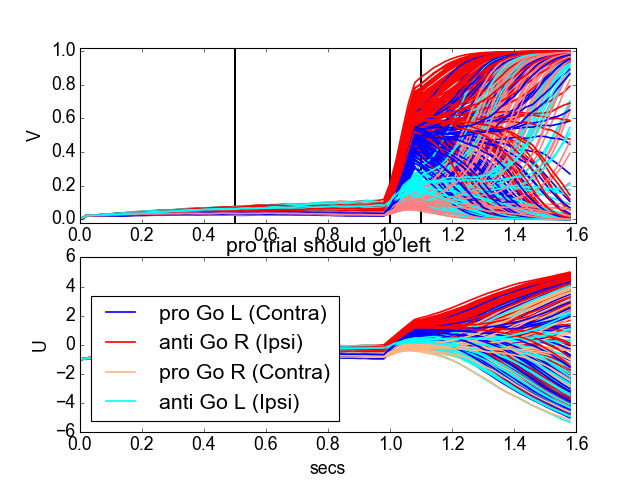

<IPython.core.display.Javascript object>


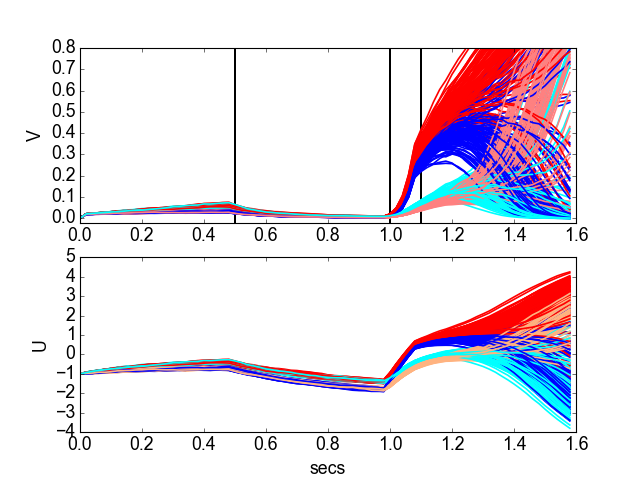

L =  25.0 %,   R =  69.0 %,   U =  6.0 %,  
L =  15.0 %,   R =  69.0 %,   U =  16.0 %,  


In [11]:
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1

do_plot = True    
ntrys = 100; 
answers = np.zeros((3,ntrys))
if do_plot:
    plt.figure(fig1); plt.clf();
    plt.figure(fig2); plt.clf();


for i in range(0, ntrys):
    t, U, V, W = run_dynamics('anti', opto='off', opto_scaling=0.5, opto_scale_on_E=-5.5,  
                       right_light_pro_extra = 0.1, right_light_input=1,
                       sigma=0.1, delay_period=0.5, target_period = 0.1, post_target_period=0.5,
                       vwi = 1.5, hwi = 1.5, const_E = 0.19, target_extra_E=1,
                       pfc_anti_input = 0.1,
                       pro_self_ex=0.7, anti_self_ex=0.7, do_plot=do_plot,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig1)
    if V[0,-1] > 0.5 and V[3,-1] > 0.5:
        answers[0,i] = 1
    elif V[1,-1] > 0.5 and V[2,-1] > 0.5:
        answers[1,i] = 1
    else:
        answers[2,i] = 1

print("L = ", 100*np.mean(answers, 1)[0], "%,  ",
     "R = ", 100*np.mean(answers, 1)[1], "%,  ",
     "U = ", 100*np.mean(answers, 1)[2], "%,  ")        


answers = np.zeros((3,ntrys))
for i in range(0, ntrys):
    t, U, V, W = run_dynamics('anti', opto='on', opto_scaling=0.5, opto_scale_on_E=-1.5,  
                       right_light_pro_extra = 0.2, right_light_input=1,
                       sigma=0.1, delay_period=0.5, target_period = 0.1, post_target_period=0.5,
                       vwi = 1.5, hwi = 1.5, const_E = 0.19, target_extra_E=1,
                       pfc_anti_input = 0.1,
                       pro_self_ex=0.7, anti_self_ex=0.7, do_plot=do_plot,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig2)
    if V[0,-1] > 0.5 and V[3,-1] > 0.5:
        answers[0,i] = 1
    elif V[1,-1] > 0.5 and V[2,-1] > 0.5:
        answers[1,i] = 1
    else:
        answers[2,i] = 1

print("L = ", 100*np.mean(answers, 1)[0], "%,  ",
     "R = ", 100*np.mean(answers, 1)[1], "%,  ",
     "U = ", 100*np.mean(answers, 1)[2], "%,  ")        



if do_plot:
    plt.figure(fig1)    
    plt.legend(['pro Go L (Contra)', 'anti Go R (Ipsi)', 'pro Go R (Contra)', 'anti Go L (Ipsi)'], 
               loc="lower left")
    plt.title("pro trial should go left")



# 7) Marino's network


<IPython.core.display.Javascript object>


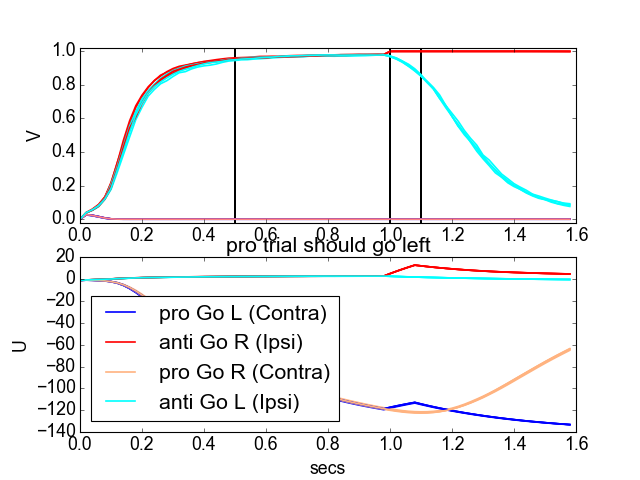

<IPython.core.display.Javascript object>


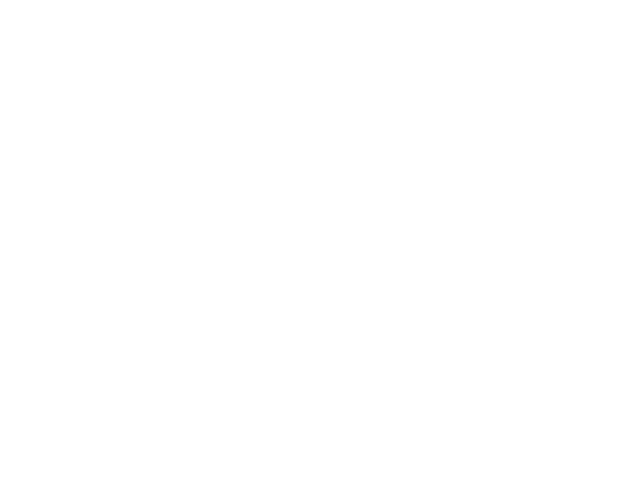

L =  0.0 %,   R =  0.0 %,   U =  100.0 %,  


In [12]:
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1

do_plot = True    
ntrys = 4; 
answers = np.zeros((3,ntrys))
if do_plot:
    plt.figure(fig1); plt.clf();
    plt.figure(fig2); plt.clf();


for i in range(0, ntrys):
    t, U, V, W = run_dynamics('anti', opto='off', opto_scaling=0.2, opto_scale_on_E=1,  
                       right_light_pro_extra = 0, right_light_input=12,
                       sigma=0.1,
                       vwi = 36, hwi = 1, const_E = 1, target_extra_E=0,
                       pfc_anti_input = 1,
                       pro_self_ex=0, anti_self_ex=0, do_plot=do_plot,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig1)
    if V[0,-1] > 0.5 and V[3,-1] > 0.5:
        answers[0,i] = 1
    elif V[1,-1] > 0.5 and V[2,-1] > 0.5:
        answers[1,i] = 1
    else:
        answers[2,i] = 1

print("L = ", 100*np.mean(answers, 1)[0], "%,  ",
     "R = ", 100*np.mean(answers, 1)[1], "%,  ",
     "U = ", 100*np.mean(answers, 1)[2], "%,  ")        


if do_plot:
    plt.figure(fig1)    
    plt.legend(['pro Go L (Contra)', 'anti Go R (Ipsi)', 'pro Go R (Contra)', 'anti Go L (Ipsi)'], 
               loc="lower left")
    plt.title("pro trial should go left")



# 8) Nullcline follower

This documents the `cline_follower()` code in the cell below, which finds nullclines for two-dimensional nonlinear dynamical systems.

The basis of the code is as follows. Let's suppose we want to follow a constant surface for some function $f()$ of two dimensions:

$$
f = f(x,y) \; \Rightarrow \\
~ \\
{\rm d}f = \frac{\partial f}{\partial x}{\rm d} x + \frac{\partial f}{\partial y}{\rm d} y 
$$

So if we want $f=\text{ constant}$, setting ${\rm d}f = 0$ gives us

$$
\frac{{\rm d}x}{{\rm d}y} = -\frac{\partial f / \partial y}{\partial f / \partial x}   \tag{1}
$$

Form a given point $(x,y)$, then, if ${\rm d}x$ and ${\rm d}y$ are small and their ratio is given by (1) above, we should have $f(x,y) = f(x+{\rm d}x, y+ {\rm d}y)$. 

There are additional tricks to the code, because as we follow a nullcline, it can curve and change direction-- that is, as we follow the nullcline it could be that at first x is increasing, but then as we go past a curve in which the nullcline heads back towards smaller x, then x will be decreasing, even while we are still moving forwards along the curve defining the nullcline. When we take steps along the nullcline, we have to take that into account. 

To do that, note that in (1) above, we could choose to find our next point by making a fixed ${\rm d}x$ step and figuring out what that implies for what ${\rm d}y$ should be. Or, we we could have done it the other way around, i.e., we could have made a fixed ${\rm d}y$ step and then figure out what that implies for ${\rm d}x$. If the nullcline is mostly horizontal, it makes sense to take the fixed steps in the $x$ direction, and then we'll be fine even if the corresponding step in the $y$ direction is zero. Conversely, if the nullcline is mostly vertical, then it makes sense to take steps in $y$ and then we'll be fine even if the corresponding step in $x$ is zero. Consequently, in the code below, we keep track of whhich axis we're taking the fixed steps along (which "branch"). This also helps us keep track of which direction (increasing or decreasing) the fixed step should be in. If we're going in the increasing direction for $x$, we won't change sign to the decreasing direction unless we go through a vertical part of the nullcline, and therefore go through a stretch of taking the fixed step along $y$.

In [13]:
def cline_follower(f, x0, y0, xlims, ylims, Nmax=2000, deriv_delta=0.0001, step_delta=0.01, 
                   dxsign=1, dysign=1, last_branch="x"):
    """
    Computes and returns a constant-value for f(x, y), from a strating point f0 = f(x0, y0).
    
    PARAMETERS:
    
      f       The function f(x,y).  Must be a function of two parameters
      
      x0, y0  The starting point for f0 = f(x0, y0)
      
      xlims   Bounding values for x; if the cline goes beyond these, calculation stops. 
              xlims must be a 2-element vector, [min_x, max_x].
              
      ylims   Bounding values for y; if the cline goes beyond these, calculation stops. 
              ylims must be a 2-element vector, [min_y, max_y].
              
      Nmax=2000   The maximum number of points to calculate for as we move along the nullcline.            
      
      deriv_delta=0.0001  The partial derivatives of f() are computed numerically with a first-order Taylor
                          approximation. This will be the change in x and y (expressed as a fraction of 
                          xlims[1]-xlims[0] and of ylimx[1]-ylims[0], respectively) used for that computation.
                          
      step_delta=0.0001  The size of the fixed step to take along an axis as we follow the cline, expressed
                         as a fraction of xlims[1]-xlims[0] and of ylimx[1]-ylims[0], respectively
                         
      dxsign=-1, dysign=-1    Whether to start with increasing or decreasing x and y as we follow the cline.
                        If your cline isn't followed in the direction you want, change the sign of these,
                        and it'll be followed in the opposite direction.
                        
      last_branch = "x"   You probably never want to fiddle with this value, but for the record, it is
                         the assumed "branch" (i.e., axis along which the fixed step size was taken) in the
                         last step.
    
    RETURNS:
    --------
    
      x, y   Vectors with a list of points, such that plt.plot(x, y) will plot the cline
      
      branch    A vector of 0s and 1s, with a 1 wherever the fixed steps were taken along the "x" 
                direction, and a 0 where they were taken along the "y" direction. This return value is
                useful mostly for debugging purposes.
    
    """

    dx = deriv_delta*np.diff(xlims);
    dy = deriv_delta*np.diff(ylims);
    dydx = -1; dxdy = -1;   # Arbitrary starting points.

    step_dx = step_delta*np.diff(xlims);
    step_dy = step_delta*np.diff(xlims);

    x = np.array([x0]); y = np.array([y0]); f0 = f(x0, y0);
    if last_branch == 'x':
        branch = np.array([1])
    else: 
        branch = np.array([0])

    for i in range(0, Nmax):
        fnow = f(x[-1], y[-1])

        dfdx = (f(x[-1]+dx, y[-1]) - fnow)/dx
        dfdy = (f(x[-1], y[-1]+dy) - fnow)/dy
        if  np.abs(dfdx) <= np.abs(dfdy): 
        # Const f will be more horiz than vertical -- dydx more numerically stable
            if last_branch != 'x':
                dxsign = np.sign(dysign*dxdy)  # Here we figure out which direction steps in x should be in 
                                               # (growing or decreasing) based on what we were doing last when
                                               # were making steps in y
                last_branch = 'x'

            dydx = - dfdx / dfdy;
            newx = x[-1] + dxsign*step_dx;
            newy = y[-1] + dxsign*step_dx*dydx;

            # Now an error-correcting adjustment
            fnow = f(newx, newy);
            dfdy = (f(newx, newy+dy) - fnow) / dy
            newy = newy + (f0 - fnow) / dfdy
            branch = np.append(branch, 1)
            
            if newx > xlims[1] or newx < xlims[0] or newy > ylims[1] or newy < ylims[0]:
                # import pdb; pdb.set_trace()
                break;

        else:
        # More vertical -- let's use dx/dy instead of dy/dx
            if last_branch != 'y':
                dysign = np.sign(dxsign*dydx)  # Here we figure out which direction steps in y should be in 
                                               # (growing or decreasing) based on what we were doing last when
                                               # were making steps in x
                last_branch = 'y'

            dxdy = - dfdy / dfdx;
            newy = y[-1] + dysign*step_dy
            newx = x[-1] + dysign*step_dy*dxdy

            # Now an error-correcting adjustment
            fnow = f(newx, newy);
            dfdx = (f(newx+dx, newy) - fnow) / dx
            newx = newx + (f0 - fnow) / dfdx
            branch = np.append(branch, 0)

            if newx > xlims[1] or newx < xlims[0] or newy > ylims[1] or newy < ylims[0]:
                # import pdb; pdb.set_trace()
                break;


        x = np.append(x, newx)
        y = np.append(y, newy)
    
    return x, y, branch


# 9) Using nullclines to design a network for unilateral opto

The initial intuition is that if opto silenced one side of the brain completely, the other side would be less inhibited. If that put the other side in a regime with a single stable point (because of too little inhibition to kick the competition into gear), then unilateral opto would lead to high activity in the contralateral PRO unit always, and would cause a reliable ipsi bias.

Note that if opto silenced one side of the brain entirely, the network would then be a two-node network. We can examine that two-node network's nullclines to understand things better, as in Wong and Wang J. Neurosci. 2005.

A further idea is to conceptually separate the activity in the 4-node network into two modes: **First**, a "symmetric" mode in which the two Anti units are identical to each other, and the two Pro units are identical to each other. In this case we boild down to a 2-node network again, in which each unit inhibits itself (e.g. because the two Anti units are connected through mutual inhibition, if the two Anti units have identical activity, then this is like self-inhibition). **Second**, an "asymmetric" mode in which the Pro unit on one side of the brain and the Anti unit on the other side have identical activity. Again this boils down to a 2-node network, but this time each node receives inhibition from the other node equal to the vertical inhibitory weight (from the unit on its own side of the brain), plus the horizontal inhibitory weight (since the unit on the other side of the brain is assumed to have activity equal to that of the vertically-oriented one on the same side).

Examining those two modes separately, we're trying to find a regime in which unilateral opto = "off" puts the network in a bistable mode, with the usual competition and resolution; but unilateral opto = "on" puts the spared side of the brain into a monostable, high activity mode (thus providing the reliable ipsi bias).

A constant E during the target period can be found that does that-- strong enough to put the dynamics in the monostable regime for unilateral opto = "on", but weak enough that during opto = "off" the network is still bistable. Unfortunately, as documented in the next section below, when these parameters are run on the full 4-node network, we don't get the right unit to win even in simple "pro" trials (let alone opto)

<IPython.core.display.Javascript object>


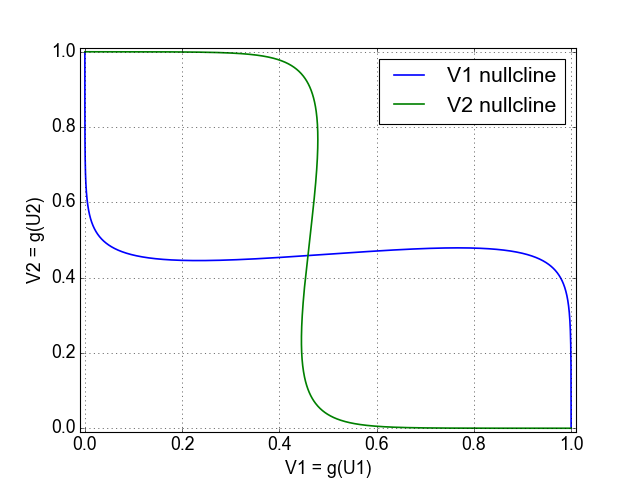

(2001,)

In [18]:
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1
    
    
# Parameters from (6) above    
# dt = 0.01    
# self_exc   = 0.7;
# mutual_inh = -1.5;
# Econst = 0.19
# Urest = -1
# gleak = 0.25
# theta = 1

w_self   = 0.7;
vwi      = -1.5;    
hwi      = -1.5;
dt = 0.01    
Econst = 0.19
Urest = -1
gleak = 0.25
theta = 1
target_extra_E = 1  # 2.3 gets us into nice monostable regime

unilateral_opto = "on"
opto_factor = 0.5    # contralateral side activity is reduced by this much. total silence would be opto_factor=0
mode = "asymmetric"
target_period = "on"

if unilateral_opto=="off" and mode=="symmetric":
    w_self += hwi
elif unilateral_opto=="off" and mode=="asymmetric":
    vwi += hwi
elif unilateral_opto=="on" and mode=="symmetric":
    w_self += opto_factor*hwi
elif unilateral_opto=="on" and mode=="asymmetric":
    vwi += opto_factor*hwi
    
    
if target_period=="on":
    Econst = Econst+target_extra_E
    

def g(x):
    return 0.5*np.tanh(x-theta) + 0.5

def dxdt(x, y):
    return (Urest - x)*gleak + Econst + w_self*g(x) + vwi*g(y)

def dUdt(U):
    W = np.array([[w_self, vwi], [vwi, w_self]])
    E = np.array([[Econst],[Econst]])

    return (Urest-U)*gleak + E + W @ g(U)

def find_fixed_point(Ustart, dt):
    U = Ustart.copy()
    for i in range(0, 10000):
        U = U + dt*dUdt(U)
    return U

U = np.array([[2],[1]])
Ustart = find_fixed_point(U, 0.01)   # We're going to follow a cline, but first we want to start from
                                     # a stable fixed point, where dxdt=0 and dydt=0, so as to make it a
                                     # nullcline


lim = 200;  xlims = np.array([-1, 1])*lim; ylims = np.array([-1, 1])*lim
x, y, branch = cline_follower(dxdt, Ustart[0], Ustart[1], xlims, ylims, 
                              dxsign=-1, dysign=-1, step_delta=0.000025, deriv_delta=0.00001)
# Note the super-small step_delta there, needed just to prevent numerical error. Lesson: if 
# the nullcline looks wonky, make step_delta smaller, see if that fixes the problem. You might
# also need to make limits bigger.

plt.figure(fig1); plt.clf();
plt.plot(g(x), g(y), label="V1 nullcline")
plt.plot(g(y), g(x), label="V2 nullcline")
ax = plt.gca()
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
ax.grid("on")
ax.set_xlabel("V1 = g(U1)")
ax.set_ylabel("V2 = g(U2)")
plt.legend()
# ax.set_aspect("equal")

np.shape(x)

# 10) Unilateral opto -- not working!!
Trying for unilateral opto, no pro bias here yet, based on the parameters found through the nullclines design above.

**Unfortunately,** it doesn't work at all, at least not in the regime explored here. It turns out that if the constant input during the target period is too large (here, 2.3), then the unit that both had the slight advantage during the delay period (because of PFC input) and received the light signal from the target does *not* become a winning unit. For high constant E, the other two units it is connected together have an advantage, and they end up being the ones that win. Contrary to initial intuition.

However, it could well be that in the regime that Marino was exploring, in which there is high activity during the delay period, not just a little bias, this approach does work.


<IPython.core.display.Javascript object>


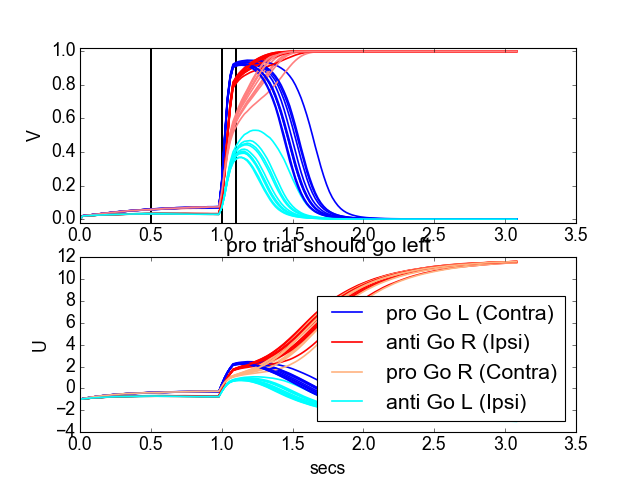

PRO should go Left
   L =  0.0 %,      R =  100.0 %,      U =  0.0 %,  


In [21]:
if using_qt:
    fig1 = 1; fig2 = 2;
else:
    fignums = plt.get_fignums();
    fig1 = 1 if len(fignums)==0 else max(fignums)+1; fig2 = fig1+1


plt.figure(fig1); plt.clf();    
ntrys = 10; answers = np.zeros((3,ntrys))

for i in range(0, ntrys):
    t, U, V, W = run_dynamics('pro', opto='off', opto_scaling=0.5, opto_scale_on_E=1,  
                       right_light_pro_extra = 0, right_light_input=1,
                       sigma=0.025,
                       vwi = 1.5, hwi = 1.5, const_E = 0.19, target_extra_E=2.3,
                       pfc_anti_input = 0.12, pfc_pro_input = 0.1, 
                       pro_self_ex=0.7, anti_self_ex=0.7, do_plot=True,
                       post_target_period = 1.99, target_period = 0.1,
                       start_U = [-1, -1, -1, -1], g_leak = 0.25, theta=1, fignum=fig1)

    if V[0,-1] > 0.5 and V[3,-1] > 0.5:
        answers[0,i] = 1
    elif V[1,-1] > 0.5 and V[2,-1] > 0.5:
        answers[1,i] = 1
    else:
        answers[2,i] = 1

print("PRO should go Left")
print("   L = ", 100*np.mean(answers, 1)[0], "%,  ",
      "   R = ", 100*np.mean(answers, 1)[1], "%,  ",
      "   U = ", 100*np.mean(answers, 1)[2], "%,  ")        

plt.figure(fig1)    
plt.legend(['pro Go L (Contra)', 'anti Go R (Ipsi)', 'pro Go R (Contra)', 'anti Go L (Ipsi)'], 
           loc="lower right")
plt.title("pro trial should go left")



In [199]:
y[-1]

-3.5511647100123578